<a href="https://colab.research.google.com/github/dwiiittt/PACD_Project/blob/main/PACD_SEGMENTASI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import convolve2d
from skimage.feature import graycomatrix, graycoprops, blob_log
from skimage.filters import gabor
from skimage import measure
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path ke file zip di Google Drive Anda
zip_path = "/content/drive/My Drive/DatasetPACDmini.zip"


dataset_path = "DatasetPACDmini/"


if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

print(f"Mengekstrak '{zip_path}'...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)
print("Dataset berhasil diekstrak.")

Mengekstrak '/content/drive/My Drive/DatasetPACDmini.zip'...
Dataset berhasil diekstrak.


In [ ]:
base_folder = os.path.join(dataset_path)

normal_path = os.path.join(base_folder, 'DatasetPACDmini/Normal')
tbc_path = os.path.join(base_folder, 'DatasetPACDmini/Tbc')

# Cek apakah folder ada dan hitung jumlah file
if os.path.exists(normal_path) and os.path.exists(tbc_path):
    print(f"Jumlah gambar normal: {len(os.listdir(normal_path))}")
    print(f"Jumlah gambar TBC: {len(os.listdir(tbc_path))}")
else:
    print("Error: Path ke folder gambar tidak ditemukan. Periksa kembali nama folder.")
    print(f"Mencari di path normal: {normal_path}")
    print(f"Mencari di path TBC: {tbc_path}")

Jumlah gambar normal: 150
Jumlah gambar TBC: 300


In [ ]:
def global_hist_eq(img_np):
    hist, bins = np.histogram(img_np.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_masked = np.ma.masked_equal(cdf, 0)
    total_pixels = img_np.size
    if cdf_masked.min() == total_pixels:
         cdf_m = cdf_masked
    else:
         cdf_m = (cdf_masked - cdf_masked.min()) * 255 / (total_pixels - cdf_masked.min())
    cdf_final = np.ma.filled(cdf_m, 0).astype('uint8')
    img_eq = cdf_final[img_np]
    return img_eq

def otsu_threshold(img):
    """Otsu's Thresholding (Manual)"""
    hist, _ = np.histogram(img.flatten(), bins=256, range=[0,256])
    total = img.size
    sum_total = np.dot(np.arange(256), hist)
    sumB, wB, wF, varMax, threshold = 0, 0, 0, 0, 0

    for i in range(256):
        wB += hist[i]
        if wB == 0: continue
        wF = total - wB
        if wF == 0: break

        sumB += i * hist[i]
        mB = sumB / wB
        mF = (sum_total - sumB) / wF

        varBetween = wB * wF * (mB - mF)**2

        if varBetween > varMax:
            varMax = varBetween
            threshold = i

    return threshold

def erosi(biner):
    """Erosi Morfologi 3x3 (Manual)"""
    h, w = biner.shape
    out = np.zeros_like(biner)
    for i in range(1, h-1):
        for j in range(1, w-1):
            patch = biner[i-1:i+2, j-1:j+2]
            out[i, j] = 255 if np.all(patch == 255) else 0
    return out

def dilasi(biner):
    """Dilasi Morfologi 3x3 (Manual)"""
    h, w = biner.shape
    out = np.zeros_like(biner)
    for i in range(1, h-1):
        for j in range(1, w-1):
            patch = biner[i-1:i+2, j-1:j+2]
            out[i, j] = 255 if np.any(patch == 255) else 0
    return out

from collections import deque
def manual_flood_fill(mask, start_r, start_c, target_value, fill_value):
    """Flood Fill berbasis BFS (Manual)"""
    h, w = mask.shape

    if mask[start_r, start_c] != target_value:
        return 0, mask

    queue = deque([(start_r, start_c)])
    mask[start_r, start_c] = fill_value
    area = 1
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    while queue:
        r, c = queue.popleft()

        for dr, dc in neighbors:
            nr, nc = r + dr, c + dc

            if 0 <= nr < h and 0 <= nc < w and mask[nr, nc] == target_value:
                mask[nr, nc] = fill_value
                queue.append((nr, nc))
                area += 1

    return area, mask

def filter_largest_components(binary_mask):
    """Filter 2 Komponen Terbesar menggunakan Flood Fill (Manual CCL)"""
    temp_mask = binary_mask.copy()
    out_mask = np.zeros_like(binary_mask)

    h, w = temp_mask.shape
    components = []

    for r in range(h):
        for c in range(w):
            if temp_mask[r, c] == 255:
                # Gunakan nilai sementara 127 untuk menandai
                area, filled_temp_mask = manual_flood_fill(temp_mask, r, c, 255, 127)
                temp_mask = filled_temp_mask

                component_pixels = np.where(temp_mask == 127)

                if area > 0:
                    components.append({'area': area, 'pixels': component_pixels})

                # Reset piksel yang sudah dihitung (127) kembali ke 0
                temp_mask[component_pixels] = 0

    components.sort(key=lambda x: x['area'], reverse=True)

    if len(components) >= 1:
        out_mask[components[0]['pixels']] = 255

    if len(components) >= 2:
        out_mask[components[1]['pixels']] = 255

    return out_mask

In [ ]:
# --- Fungsi: Segmentasi Paru-Paru dengan GHE + Otsu + Morphology + Flood Fill (Revisi Tanpa Cropping) ---
def segmentasi_paru_floodfill(image_path):
    # ... [Langkah 1 s.d. 4 tetap sama: GHE, Otsu, Morph (Erosi awal), Filter Largest Components] ...

    img = Image.open(image_path).convert("L")
    img_np = np.array(img)
    img_eq = global_hist_eq(img_np)
    t = otsu_threshold(img_eq)
    binary = (img_eq < t).astype(np.uint8) * 255
    morph = dilasi(erosi(binary))
    morph = erosi(morph)
    final_mask = filter_largest_components(morph)

    # 5. MORFOLOGI PASCA-FILTER (Mengganti Dilasi Pemulihan dan Cropping)

    # 5a. Closing: Dilasi (isi lubang internal) diikuti Erosi (memperhalus batas)
    # Ini membantu mengisi lubang yang ada di dalam paru-paru yang tersegmentasi (bronkus/pembuluh darah).
    closed_mask = dilasi(final_mask)
    closed_mask = erosi(closed_mask)

    # 5b. Erosi Ekstra: Membersihkan batas luar dan menghilangkan sisa noise kecil
    # Lakukan erosi 2-3 kali untuk menyusutkan tepi mask dari latar belakang/tulang yang berdekatan.
    cleaned_mask = erosi(closed_mask)
    cleaned_mask = erosi(cleaned_mask)

    # 6. Terapkan mask
    segmented = np.where(cleaned_mask == 255, img_eq, 0)

    return img_np, img_eq, cleaned_mask, segmented

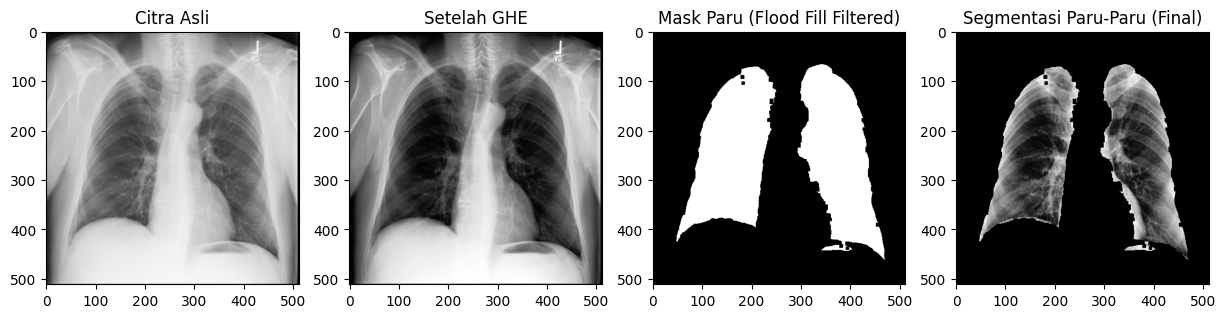

In [ ]:
#sample_img = os.path.join(tbc_path, os.listdir(tbc_path)[90])
sample_img = os.path.join(normal_path, os.listdir(normal_path)[54])
orig, img_eq, cleaned_mask, segmented = segmentasi_paru_floodfill(sample_img)

plt.figure(figsize=(15,5))
plt.subplot(1,4,1); plt.imshow(orig, cmap='gray'); plt.title('Citra Asli')
plt.subplot(1,4,2); plt.imshow(img_eq, cmap='gray'); plt.title('Setelah GHE')
plt.subplot(1,4,3); plt.imshow(cleaned_mask, cmap='gray'); plt.title('Mask Paru (Flood Fill Filtered)')
plt.subplot(1,4,4); plt.imshow(segmented, cmap='gray'); plt.title('Segmentasi Paru-Paru (Final)')
plt.show()

In [ ]:
def extract_features_manual_numpy(image):
    """
    Ekstraksi fitur HANYA menggunakan Numpy (sesuai aturan).
    Ini menggantikan fungsi lama Anda yang menggunakan skimage/cv2.
    """
    if image is None or np.all(image == 0):
        # Mengembalikan 5 fitur
        return [0] * 5

    # Ambil piksel di dalam paru-paru
    pixels = image[image > 0]

    if len(pixels) == 0:
        return [0] * 5

    # 1. Rata-rata Intensitas
    mean_val = np.mean(pixels)

    # 2. Standar Deviasi (Ukuran tekstur kasar)
    std_val = np.std(pixels)

    # 3. Area Paru-paru (Normalisasi)
    h, w = image.shape
    area_ratio = len(pixels) / (h * w)

    # 4. Fitur Area (Upper vs Lower)
    cutoff = int(h * 0.8) # 80% atas
    upper_pixels = image[:cutoff, :][image[:cutoff, :] > 0]
    lower_pixels = image[cutoff:, :][image[cutoff:, :] > 0]

    mean_upper = np.mean(upper_pixels) if upper_pixels.size > 0 else 0
    mean_lower = np.mean(lower_pixels) if lower_pixels.size > 0 else 0

    # 5. Effusion Score (Perbedaan intensitas atas dan bawah)
    effusion_score = mean_lower - mean_upper

    return [mean_val, std_val, area_ratio, mean_upper, effusion_score]
# ===================================================================


# === Dataset Ekstraksi Fitur (Memanggil fungsi manual baru) ===
features, labels = [], []

print("Memproses gambar Normal...")
for img_name in tqdm(os.listdir(normal_path), desc="Normal", unit="img"):
    img_path = os.path.join(normal_path, img_name)
    _, _, _, segmented = segmentasi_paru_floodfill(img_path)

    if segmented is not None:
        # Memanggil fungsi EKSTRAKSI FITUR BARU
        feature_vector = extract_features_manual_numpy(segmented)
        features.append(feature_vector)
        labels.append(0) # 0 untuk Normal

print("Memproses gambar TBC...")
for img_name in tqdm(os.listdir(tbc_path), desc="TBC", unit="img"):
    img_path = os.path.join(tbc_path, img_name)
    _, _, _, segmented = segmentasi_paru_floodfill(img_path)

    if segmented is not None:
        # Memanggil fungsi EKSTRAKSI FITUR BARU
        feature_vector = extract_features_manual_numpy(segmented)
        features.append(feature_vector)
        labels.append(1) # 1 untuk TBC

X = np.array(features)
y = np.array(labels)

if len(X) > 0:
    print(f"\nTotal data yang diproses: {len(X)}")
    print(f"Dimensi fitur (X): {X.shape}")
    print(f"Dimensi label (y): {y.shape}")

    # === KLASIFIKASI (Menggunakan SKLEARN, asumsi ini boleh) ===
    # Split data (Cara sederhana)
    combined = list(zip(X, y))
    random.shuffle(combined)
    X_shuffled, y_shuffled = zip(*combined)
    X_shuffled = np.array(X_shuffled)
    y_shuffled = np.array(y_shuffled)

    split_idx = int(len(X) * 0.8) # 80% train, 20% test
    X_train, X_test = X_shuffled[:split_idx], X_shuffled[split_idx:]
    y_train, y_test = y_shuffled[:split_idx], y_shuffled[split_idx:]

    print(f"Data Latih: {len(X_train)}, Data Uji: {len(X_test)}")

    # Latih SVM
    print("Melatih SVM...")
    model = SVC(kernel='linear', C=1.0)
    model.fit(X_train, y_train)

    # Prediksi
    y_pred = model.predict(X_test)

    # Evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    print(f"==========================================")
    print(f"Akurasi Model SVM (pada data uji): {accuracy * 100:.2f}%")
    print(f"==========================================")

else:
    print("Tidak ada data yang berhasil diproses. Periksa proses segmentasi.")

Memproses gambar Normal...


Normal: 100%|██████████| 150/150 [42:36<00:00, 17.04s/img]


Memproses gambar TBC...


TBC:  56%|█████▋    | 169/300 [47:23<36:26, 16.69s/img]